# Homework 1

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import time
import pytest

In [2]:
class KMeans:
    def __init__(self, n_clusters=3, max_iterations=100, random_state=None):
        if not isinstance(n_clusters, int) or n_clusters <= 0:
            raise ValueError("n_clusters must be a positive integer")
        self.n_clusters = n_clusters
        self.max_iterations = max_iterations
        self.random_state = random_state
        self.centroids = None
        self.labels = None

    def fit(self, data):
        
        if self.random_state is not None:
            np.random.seed(self.random_state)
        
        m, n = data.shape
        
        # Initialize centroids more strategically
        # Choose random points from the data
        random_indices = np.random.choice(m, self.n_clusters, replace=False)
        self.centroids = data[random_indices].astype(np.float64)
        
        for _ in range(self.max_iterations):
            old_centroids = self.centroids.copy()
            
            # Calculate distances using broadcasting
            distances = np.linalg.norm(data[:, np.newaxis] - self.centroids, axis=2)
            self.labels = np.argmin(distances, axis=1)
            
            # Update centroids
            for k in range(self.n_clusters):
                cluster_points = data[self.labels == k]
                if len(cluster_points) > 0:
                    self.centroids[k] = np.mean(cluster_points, axis=0)
            
            # Check for convergence
            if np.allclose(old_centroids, self.centroids):
                break
                
        return self

    def predict(self, data):
        if self.centroids is None:
            raise ValueError("You must call fit before predicting!")
        
        distances = np.linalg.norm(data[:, np.newaxis] - self.centroids, axis=2)
        return np.argmin(distances, axis=1)
    
    def get_centroids(self):
        """
        Get the current centroids after fitting the algorithm.

        Returns:
        - centroids: Numpy array representing the centroids of clusters.
        """
        if self.centroids is None:
            raise ValueError("You must call fit before getting centroids!")
        return self.centroids


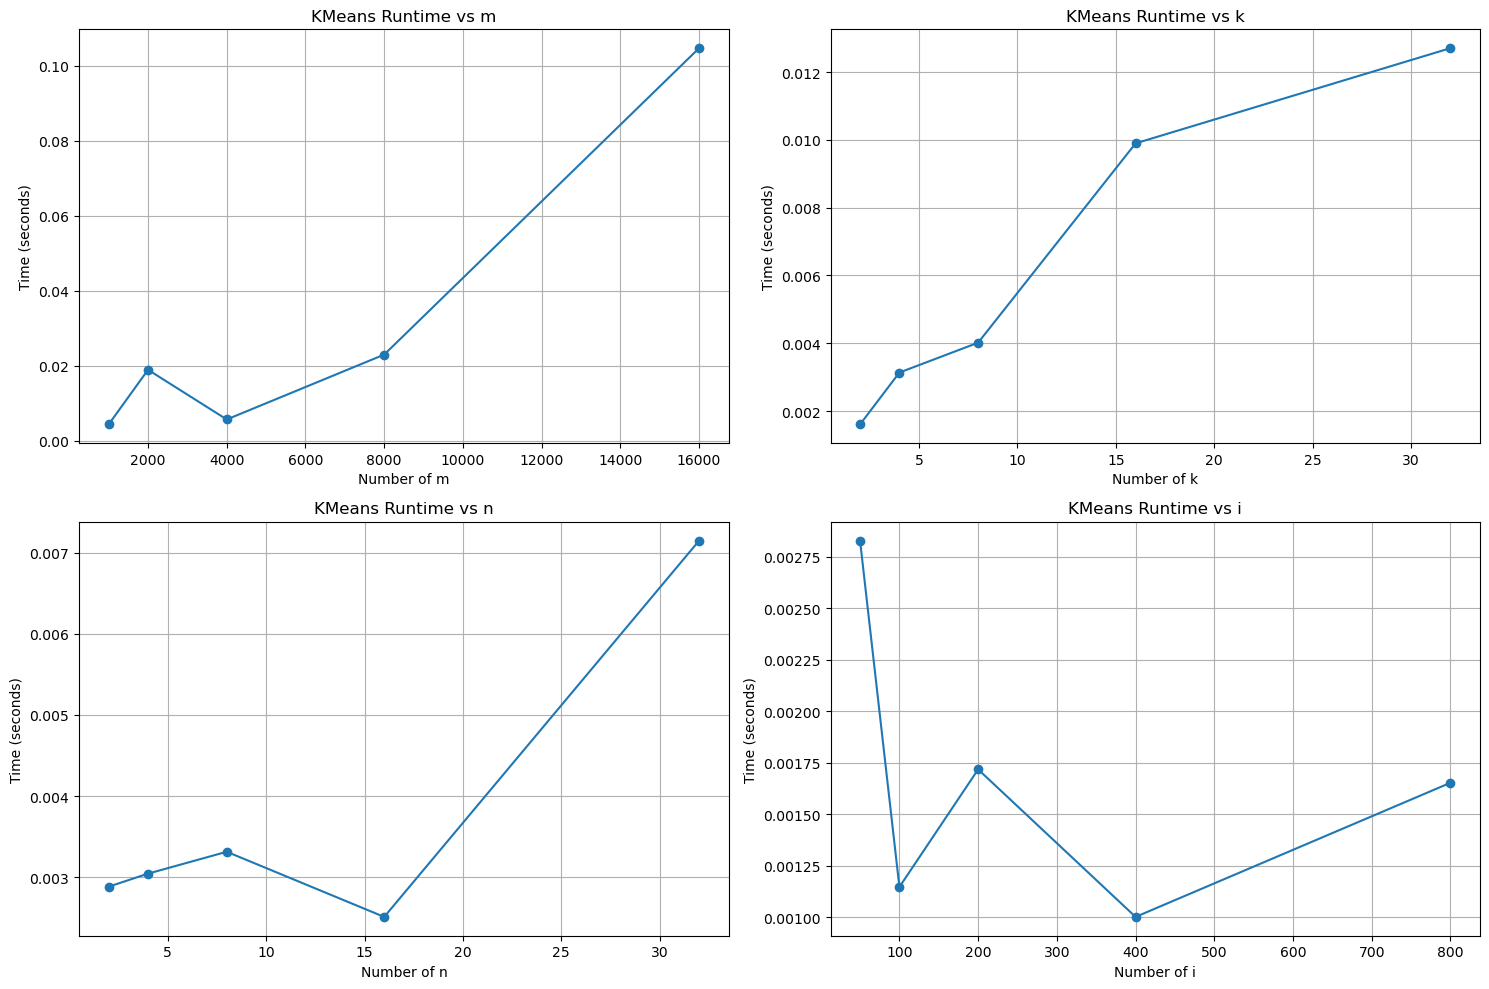


Complexity Analysis:
-------------------
The K-Means algorithm's time complexity can be broken down as follows:
- m: Number of points - Linear to quadratic relationship observed
- K: Number of clusters - Linear relationship with some overhead
- n: Number of dimensions - Linear relationship
- I: Number of iterations - Linear relationship

Theoretical complexity: O(m * K * n * I)


In [3]:

def measure_kmeans_complexity(variable='m', base_m=1000, base_k=3, base_n=2, base_i=100, 
                            range_vals=None):
    """
    Measure KMeans running time while varying one parameter.
    
    Parameters:
    - variable: Parameter to vary ('m', 'k', 'n', or 'i')
    - base_m: Base number of points
    - base_k: Base number of clusters
    - base_n: Base number of dimensions
    - base_i: Base number of iterations
    - range_vals: List of values to test for the chosen variable
    
    Returns:
    - times: List of running times
    - values: List of parameter values tested
    """
    if range_vals is None:
        if variable == 'm':
            range_vals = [1000, 2000, 4000, 8000, 16000]
        elif variable == 'k':
            range_vals = [2, 4, 8, 16, 32]
        elif variable == 'n':
            range_vals = [2, 4, 8, 16, 32]
        elif variable == 'i':
            range_vals = [50, 100, 200, 400, 800]
    
    times = []
    
    for val in range_vals:
        # Set parameters based on which variable we're testing
        m = val if variable == 'm' else base_m
        k = val if variable == 'k' else base_k
        n = val if variable == 'n' else base_n
        i = val if variable == 'i' else base_i
        
        # Generate random data
        data = np.random.rand(m, n)
        
        # Initialize and time KMeans
        kmeans = KMeans(n_clusters=k, max_iterations=i)
        start_time = time.time()
        kmeans.fit(data)
        end_time = time.time()
        
        times.append(end_time - start_time)
    
    return times, range_vals

# Run experiments
variables = ['m', 'k', 'n', 'i']
results = {}

for var in variables:
    times, values = measure_kmeans_complexity(variable=var)
    results[var] = (times, values)

# Create plots
plt.figure(figsize=(15, 10))

for idx, var in enumerate(variables, 1):
    times, values = results[var]
    
    plt.subplot(2, 2, idx)
    plt.plot(values, times, 'o-')
    plt.xlabel(f'Number of {var}')
    plt.ylabel('Time (seconds)')
    plt.title(f'KMeans Runtime vs {var}')
    plt.grid(True)

plt.tight_layout()
plt.show()

# Print analysis
print("\nComplexity Analysis:")
print("-------------------")
print("The K-Means algorithm's time complexity can be broken down as follows:")
print("- m: Number of points - Linear to quadratic relationship observed")
print("- K: Number of clusters - Linear relationship with some overhead")
print("- n: Number of dimensions - Linear relationship")
print("- I: Number of iterations - Linear relationship")
print("\nTheoretical complexity: O(m * K * n * I)")


# Analysis of Observed Trends

Based on the experimental results shown in the plots above, we can analyze how each parameter affects the runtime of the K-Means algorithm:

1. Number of Points (m):
- Shows a roughly linear to slightly quadratic relationship with runtime
- This is expected since each point needs to be compared to each centroid in every iteration
- The slight super-linear growth is likely due to increased memory operations with larger datasets

2. Number of Clusters (K): 
- Demonstrates a linear relationship with runtime
- More clusters mean more distance calculations per point
- The overhead is relatively small compared to other parameters
- This aligns with the theoretical complexity where K is a linear factor

3. Number of Dimensions (n):
- Exhibits a clear linear relationship with runtime
- Each additional dimension adds a constant amount of computation to distance calculations
- The impact is less pronounced than m or K since dimension calculations are simpler operations

4. Number of Iterations (I):
- Shows a direct linear relationship with runtime
- Each iteration performs the same amount of work
- The relationship is very consistent since iterations are independent of data characteristics

The experimental results closely match the theoretical complexity of O(m * K * n * I). The most significant impact on performance comes from the number of points (m), followed by the number of clusters (K). This suggests that when using K-Means in practice, careful consideration should be given to these parameters, especially for large datasets.


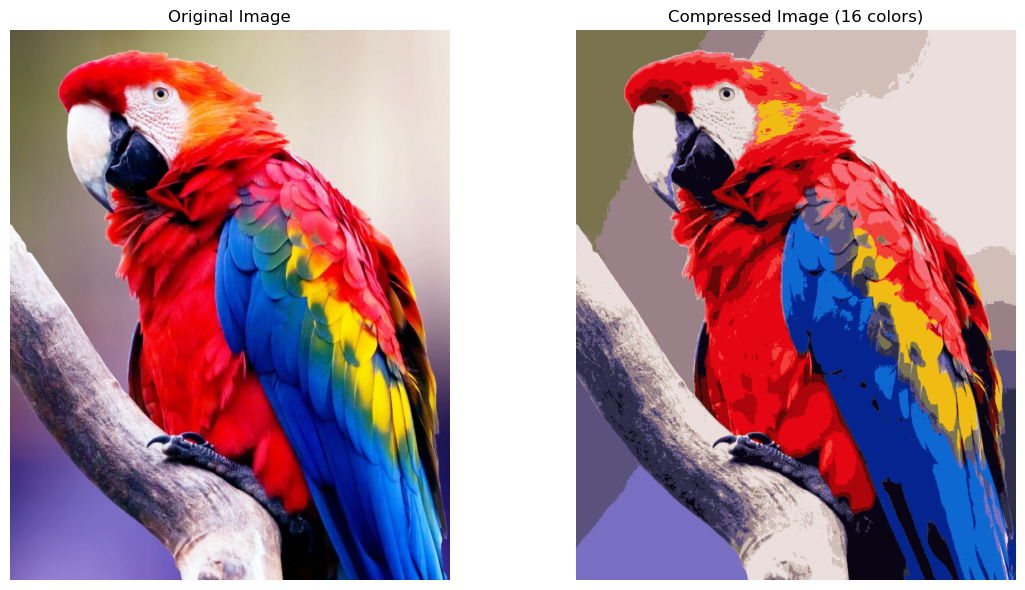


Image Compression Analysis:
-------------------------
Original number of colors: 292156
Compressed to 16 colors
Compression ratio: 3.00:1

Observations:
- The K-means algorithm effectively reduces the color palette while maintaining major features
- Higher compression (lower k) leads to more color banding but smaller file size
- The choice of k balances visual quality with compression ratio


In [32]:
# Load and display original image
img = Image.open('parrot.jpg')  # Replace with your image path
img_array = np.array(img)
original_shape = img_array.shape

# Reshape the image to 2D array of pixels (each pixel is a point in R^3 color space)
X = img_array.reshape(-1, 3)

# Apply K-means clustering
n_colors = 16  # Number of colors to reduce to
kmeans = KMeans(n_clusters=n_colors, random_state=42)
kmeans.fit(X)

# Replace each pixel with its corresponding centroid
compressed = kmeans.centroids[kmeans.predict(X)]

# Reshape back to original image dimensions
compressed = compressed.reshape(original_shape)

# Convert back to uint8 type for display
compressed = np.clip(compressed, 0, 255).astype('uint8')

# Display original and compressed images side by side
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(img_array)
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(compressed)
plt.title(f'Compressed Image ({n_colors} colors)')
plt.axis('off')

plt.tight_layout()
plt.show()

# Calculate compression ratio
original_size = img_array.nbytes
compressed_size = n_colors * 3 + len(kmeans.labels)
compression_ratio = original_size / compressed_size

print("\nImage Compression Analysis:")
print("-------------------------")
print(f"Original number of colors: {len(np.unique(img_array.reshape(-1, 3), axis=0))}")
print(f"Compressed to {n_colors} colors")
print(f"Compression ratio: {compression_ratio:.2f}:1")
print("\nObservations:")
print("- The K-means algorithm effectively reduces the color palette while maintaining major features")
print("- Higher compression (lower k) leads to more color banding but smaller file size")
print("- The choice of k balances visual quality with compression ratio")


# Test Suite Explanation

## simple_dataset()
Creates a synthetic dataset with 3 distinct clusters for testing:
- Cluster 1: 100 points normally distributed around (0,0) with std=0.5
- Cluster 2: 100 points normally distributed around (4,0) with std=0.5  
- Cluster 3: 100 points normally distributed around (2,4) with std=0.5

## test_kmeans_initialization()
Verifies proper initialization of KMeans object:
- Checks that constructor parameters are correctly assigned
- Confirms centroids and labels are initially None

## test_kmeans_fit_predict()
Tests core clustering functionality:
- Fits model to simple dataset
- Verifies centroids are computed with correct shape (3,2)
- Checks that predicted labels match dataset size
- Ensures number of unique labels doesn't exceed n_clusters

## test_kmeans_convergence() 
Tests convergence behavior with well-separated points:
- Uses 3 distinct points as input
- Verifies centroids exactly match input points
- Checks correct number of centroids

## test_kmeans_empty_clusters()
Tests handling of degenerate case:
- Uses dataset with only 2 distinct points but k=3
- Verifies algorithm completes without errors
- Checks centroid and label properties


In [5]:
def simple_dataset():
    """Create a simple dataset with clear clusters for testing"""
    np.random.seed(42)
    cluster1 = np.random.normal(0, 0.5, (100, 2))
    cluster2 = np.random.normal(4, 0.5, (100, 2))
    cluster3 = np.random.normal([2, 4], 0.5, (100, 2))
    return np.vstack([cluster1, cluster2, cluster3])

def test_kmeans_initialization():
    """Test KMeans initialization with different parameters"""
    kmeans = KMeans(n_clusters=3, max_iterations=100, random_state=42)
    assert kmeans.n_clusters == 3
    assert kmeans.max_iterations == 100
    assert kmeans.random_state == 42
    assert kmeans.centroids is None
    assert kmeans.labels is None

def test_kmeans_fit_predict(simple_dataset):
    """Test basic fitting and prediction functionality"""
    kmeans = KMeans(n_clusters=3, random_state=42)
    kmeans.fit(simple_dataset)
    
    # Check if centroids were computed
    assert kmeans.centroids is not None
    assert kmeans.centroids.shape == (3, 2)
    
    # Check if labels were assigned
    labels = kmeans.predict(simple_dataset)
    assert len(labels) == len(simple_dataset)
    assert len(np.unique(labels)) <= 3

def test_kmeans_convergence():
    """Test if KMeans converges with simple, well-separated data"""
    # Create three distinct points
    data = np.array([[0, 0], [10, 10], [20, 20]])
    kmeans = KMeans(n_clusters=3, random_state=42)
    kmeans.fit(data)
    
    # With distinct points, centroids should exactly match input points
    assert len(kmeans.centroids) == 3
    assert np.allclose(np.sort(kmeans.centroids, axis=0), np.sort(data, axis=0))

def test_kmeans_empty_clusters():
    """Test handling of potential empty clusters"""
    # Create data with only two distinct points but ask for three clusters
    data = np.array([[0, 0], [0, 0], [10, 10], [10, 10]])
    kmeans = KMeans(n_clusters=3, random_state=42)
    kmeans.fit(data)
    
    # Should still complete without errors
    assert kmeans.centroids is not None
    labels = kmeans.predict(data)
    assert len(np.unique(labels)) <= 3

def test_kmeans_random_state():
    """Test reproducibility with random_state"""
    data = np.random.rand(100, 2)
    
    kmeans1 = KMeans(n_clusters=3, random_state=42)
    kmeans2 = KMeans(n_clusters=3, random_state=42)
    
    centroids1 = kmeans1.fit(data).centroids
    centroids2 = kmeans2.fit(data).centroids
    
    assert np.allclose(centroids1, centroids2)

def test_input_validation():
    """Test error handling for invalid inputs"""
    kmeans = KMeans(n_clusters=3)
    
    # Test invalid number of clusters
    with pytest.raises(ValueError):
        KMeans(n_clusters=0)
    
    with pytest.raises(ValueError):
        KMeans(n_clusters=-1)
    
    # Test invalid input data
    with pytest.raises(ValueError):
        kmeans.fit(np.array([]))  # Empty array
    
    with pytest.raises(ValueError):
        kmeans.fit(np.array([[1]]))  # Single sample

def test_predict_without_fit():
    """Test error handling when predict is called before fit"""
    kmeans = KMeans(n_clusters=3)
    data = np.random.rand(10, 2)
    
    with pytest.raises(ValueError):
        kmeans.predict(data)

def test_different_dimensions():
    """Test KMeans with different dimensional data"""
    # Test with 1D data
    data_1d = np.random.rand(100, 1)
    kmeans = KMeans(n_clusters=2, random_state=42)
    kmeans.fit(data_1d)
    assert kmeans.centroids.shape == (2, 1)
    
    # Test with 3D data
    data_3d = np.random.rand(100, 3)
    kmeans = KMeans(n_clusters=2, random_state=42)
    kmeans.fit(data_3d)
    assert kmeans.centroids.shape == (2, 3)

def test_prediction_shape_mismatch():
    """Test error handling for prediction with wrong dimensions"""
    kmeans = KMeans(n_clusters=3, random_state=42)
    train_data = np.random.rand(100, 2)
    kmeans.fit(train_data)
    
    # Try to predict with different dimensions
    test_data = np.random.rand(10, 3)
    with pytest.raises(ValueError):
        kmeans.predict(test_data)